# 🧁 Bakery Sales Forecasting - Step 2: Dataset Characteristics


This notebook analyzes the characteristics of the prepared dataset.  
We will explore:
- Dataset structure
- Missing values
- Feature distributions
- Correlation patterns


In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sale_weather_kiwo = pd.read_csv("prepared_sales_weather_event_data.csv", parse_dates=["Datum"])


## 📋 Dataset Overview

In [2]:

sale_weather_kiwo.info()
sale_weather_kiwo.head()
print(f"Rows: {sale_weather_kiwo.shape[0]}, Columns: {sale_weather_kiwo.shape[1]}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10119 entries, 0 to 10118
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   9334 non-null   float64       
 1   Datum                10119 non-null  datetime64[ns]
 2   Warengruppe          9334 non-null   float64       
 3   Umsatz               9334 non-null   float64       
 4   Bewoelkung           10048 non-null  float64       
 5   Temperatur           10103 non-null  float64       
 6   Windgeschwindigkeit  10103 non-null  float64       
 7   Wettercode           7581 non-null   float64       
 8   KielerWoche          10119 non-null  int64         
 9   DayOfWeek            10119 non-null  int64         
 10  Weekend              10119 non-null  int64         
 11  Month                10119 non-null  int64         
 12  Year                 10119 non-null  int64         
 13  Week                 10119 non-

## ❓ Missing Values

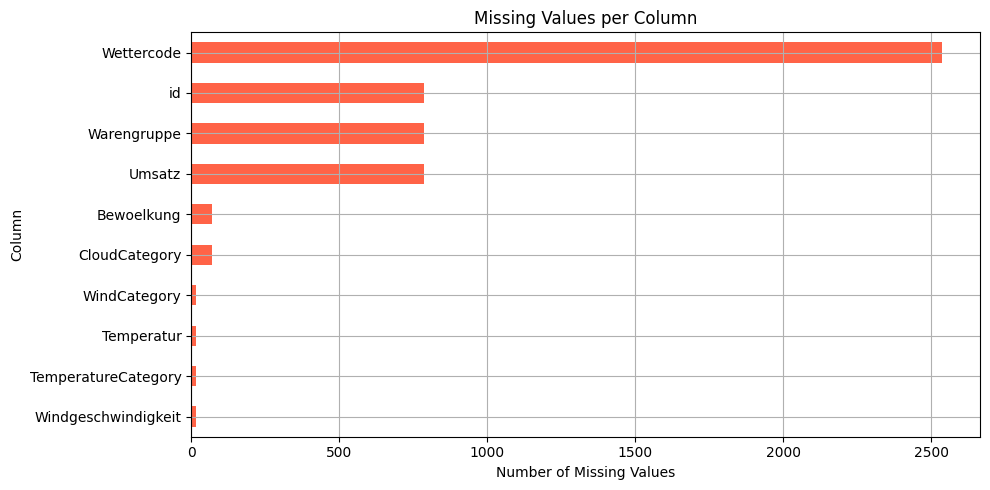

In [4]:
import matplotlib.pyplot as plt

missing_counts = sale_weather_kiwo.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]

plt.figure(figsize=(10, 5))
missing_counts.sort_values().plot(kind='barh', color='tomato')
plt.title("Missing Values per Column")
plt.xlabel("Number of Missing Values")
plt.ylabel("Column")
plt.grid(True)
plt.tight_layout()
plt.show()

## 📊 Feature Distributions – Numerical

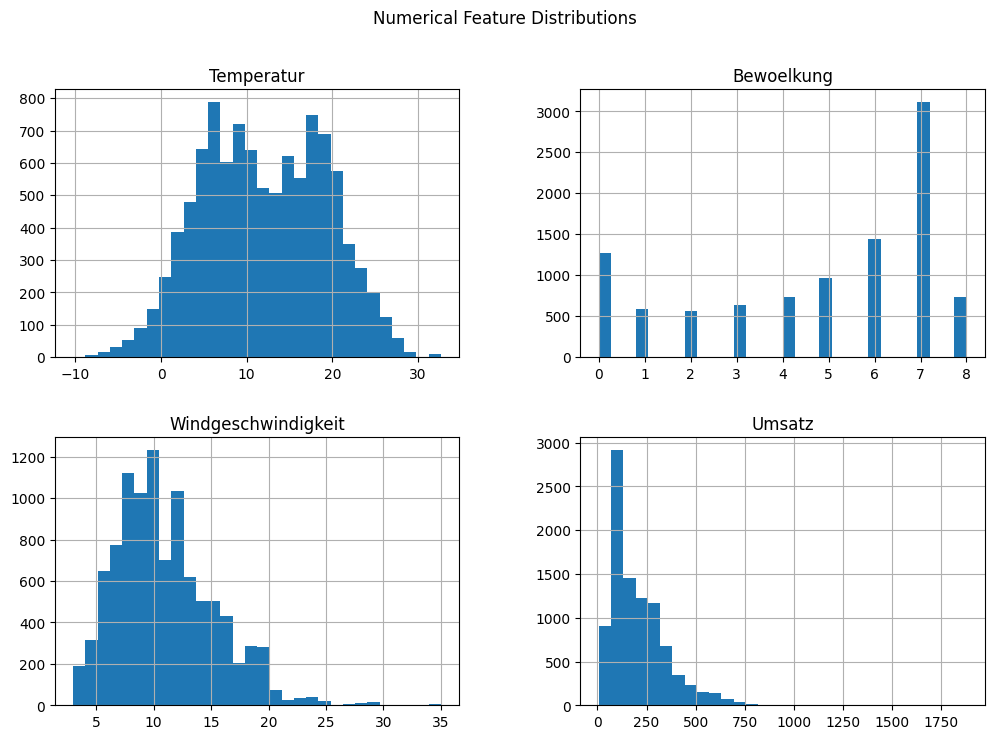

In [7]:

sale_weather_kiwo[['Temperatur', 'Bewoelkung', 'Windgeschwindigkeit', 'Umsatz']].hist(
    bins=30, figsize=(12, 8))
plt.suptitle("Numerical Feature Distributions")
plt.show()


## 📊 Feature Distributions – Categorical

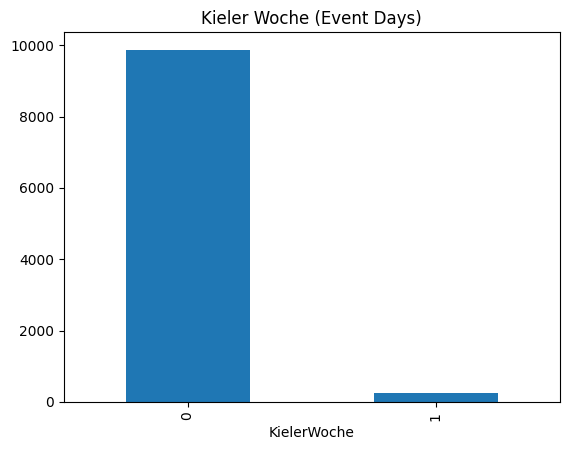

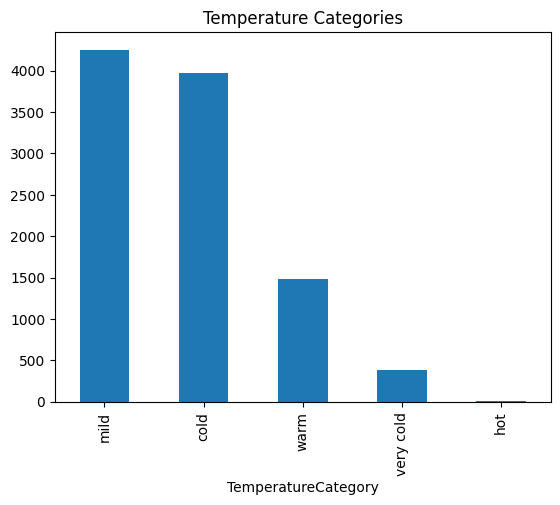

In [8]:

sale_weather_kiwo['KielerWoche'].value_counts().plot(kind='bar', title="Kieler Woche (Event Days)")
plt.show()

sale_weather_kiwo['TemperatureCategory'].value_counts().plot(kind='bar', title="Temperature Categories")
plt.show()


## 🔗 Correlation Analysis

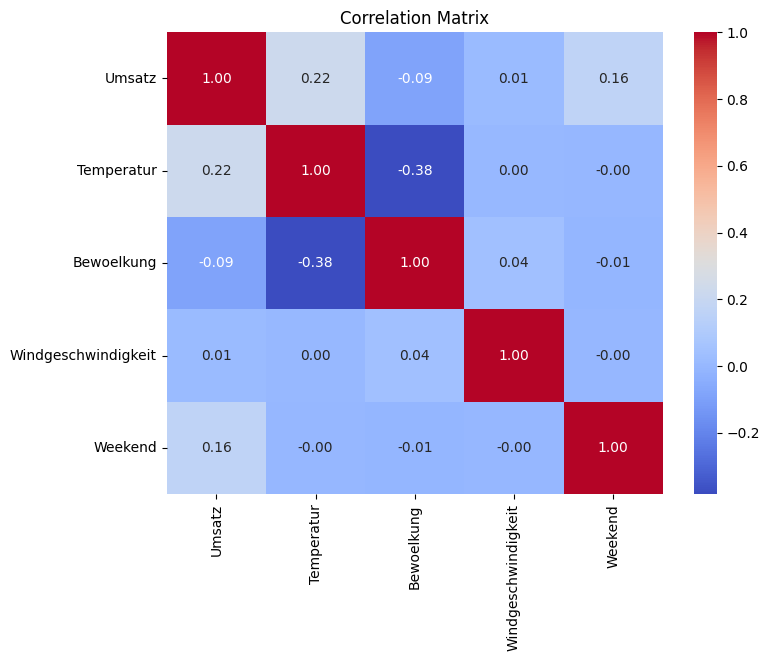

In [9]:

corr = sale_weather_kiwo[['Umsatz', 'Temperatur', 'Bewoelkung', 'Windgeschwindigkeit', 'Weekend']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()


## ⏳ Sales Over Time

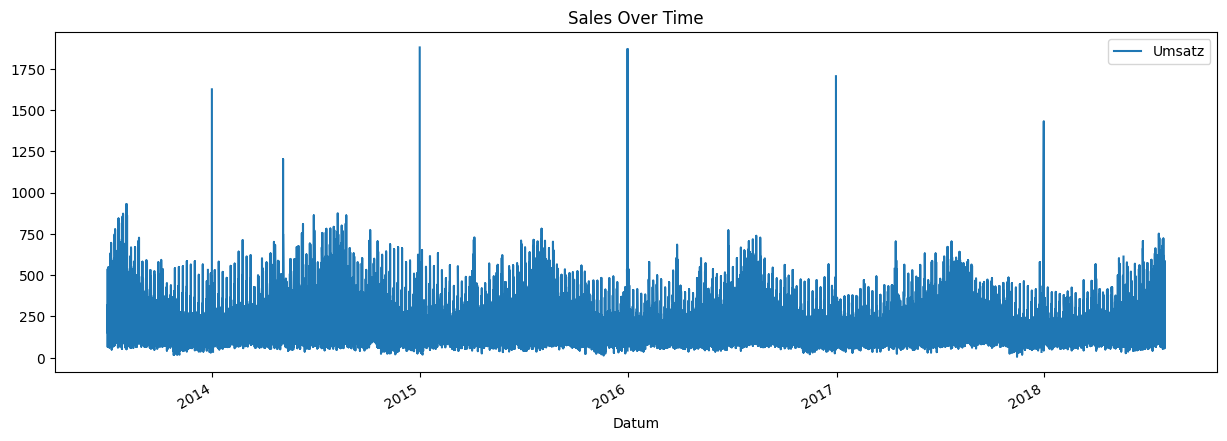

In [10]:

sale_weather_kiwo.plot(x='Datum', y='Umsatz', figsize=(15,5), title='Sales Over Time')
plt.show()


## 📦 Sales by Category (Weekend / Event)

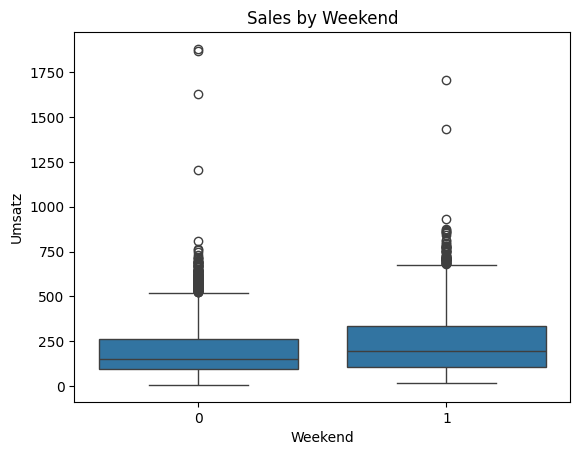

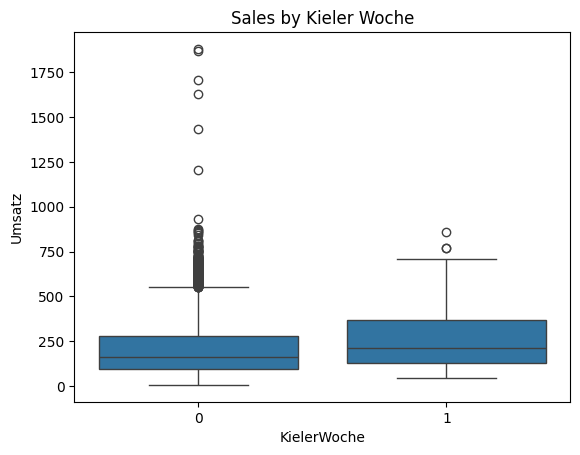

In [11]:

sns.boxplot(x='Weekend', y='Umsatz', data=sale_weather_kiwo)
plt.title("Sales by Weekend")
plt.show()

sns.boxplot(x='KielerWoche', y='Umsatz', data=sale_weather_kiwo)
plt.title("Sales by Kieler Woche")
plt.show()
